
Type 'exit' to quit the program.

Predicted emotion vector (sentiment scores):
[0.04111035 0.03604307 0.03800835 0.03496695 0.03598181 0.04045547
 0.03471437 0.03704555 0.03145973 0.03316194 0.0337053  0.03449421
 0.03252136 0.03921186 0.03264029 0.03902722 0.02972591 0.04052214
 0.05663706 0.02853242 0.03684086 0.03554907 0.03293742 0.03205198
 0.0306191  0.03325623 0.03215588 0.03662408]
Sentiment vector shape: torch.Size([28])
Sentiment vector: tensor([0.0411, 0.0360, 0.0380, 0.0350, 0.0360, 0.0405, 0.0347, 0.0370, 0.0315,
        0.0332, 0.0337, 0.0345, 0.0325, 0.0392, 0.0326, 0.0390, 0.0297, 0.0405,
        0.0566, 0.0285, 0.0368, 0.0355, 0.0329, 0.0321, 0.0306, 0.0333, 0.0322,
        0.0366])
Generated image shape: (200, 200, 3)


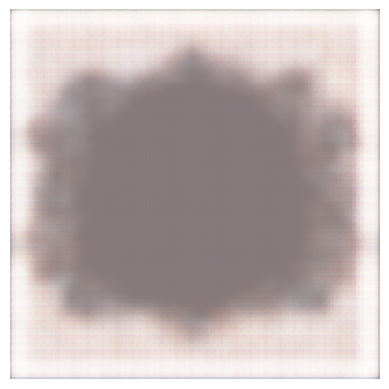


Predicted emotion vector (sentiment scores):
[0.03737801 0.03227913 0.04386199 0.04265842 0.03633047 0.04034366
 0.0358097  0.03738609 0.03078211 0.03629126 0.03798691 0.03940566
 0.03489758 0.03496779 0.03142244 0.03690893 0.03196224 0.03397011
 0.03616068 0.03047594 0.03621643 0.03415242 0.03408438 0.03188987
 0.03250371 0.03632112 0.03328811 0.04026485]
Sentiment vector shape: torch.Size([28])
Sentiment vector: tensor([0.0374, 0.0323, 0.0439, 0.0427, 0.0363, 0.0403, 0.0358, 0.0374, 0.0308,
        0.0363, 0.0380, 0.0394, 0.0349, 0.0350, 0.0314, 0.0369, 0.0320, 0.0340,
        0.0362, 0.0305, 0.0362, 0.0342, 0.0341, 0.0319, 0.0325, 0.0363, 0.0333,
        0.0403])
Generated image shape: (200, 200, 3)


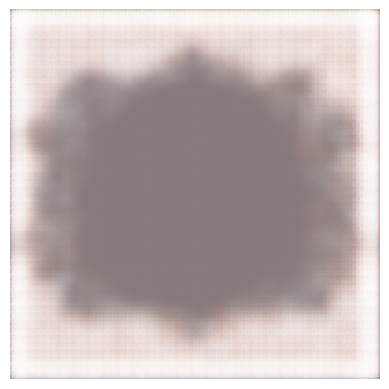


Predicted emotion vector (sentiment scores):
[0.03735575 0.03564681 0.0380293  0.03799977 0.0381505  0.03439647
 0.03518905 0.03572986 0.03482463 0.03711676 0.03659089 0.03732179
 0.03582586 0.03757013 0.03578046 0.03251828 0.03135408 0.03592564
 0.03360068 0.03483699 0.03461295 0.03455981 0.03682804 0.03378442
 0.03195889 0.03578953 0.03596084 0.04074182]
Sentiment vector shape: torch.Size([28])
Sentiment vector: tensor([0.0374, 0.0356, 0.0380, 0.0380, 0.0382, 0.0344, 0.0352, 0.0357, 0.0348,
        0.0371, 0.0366, 0.0373, 0.0358, 0.0376, 0.0358, 0.0325, 0.0314, 0.0359,
        0.0336, 0.0348, 0.0346, 0.0346, 0.0368, 0.0338, 0.0320, 0.0358, 0.0360,
        0.0407])
Generated image shape: (200, 200, 3)


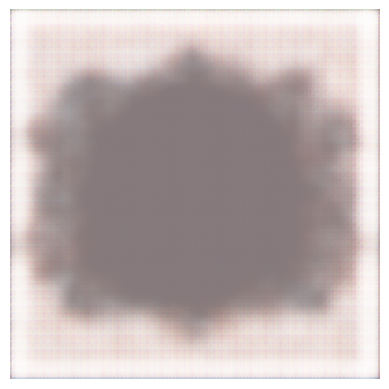

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import re
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd


class VAE(nn.Module):
    def __init__(self, latent_dim=28, image_size=(200, 200)):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.image_size = image_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        
        self.flattened_size = self.calculateFlattenedSize(image_size)
        
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc21 = nn.Linear(512, self.latent_dim)
        self.fc22 = nn.Linear(512, self.latent_dim)

        self.fc3 = nn.Linear(self.latent_dim, 512)
        self.fc4 = nn.Linear(512, self.flattened_size)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def calculateFlattenedSize(self, shape):
        x = torch.zeros(1, 3, *shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(torch.prod(torch.tensor(x.size())))

    def encoder(self, x, sentiment_vector):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        h1 = nn.functional.relu(self.fc1(x))
        mu = self.fc21(h1) + sentiment_vector  
        logvar = self.fc22(h1)
        return mu, logvar

    def decoder(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        h4 = nn.functional.relu(self.fc4(h3))
        batch_size = z.size(0)
        h4 = h4.view(batch_size, 128, 25, 25)

        x = nn.functional.relu(self.deconv1(h4))
        x = nn.functional.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  
        return x

    def forward(self, x, sentiment_vector):
        mu, logvar = self.encoder(x, sentiment_vector)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

def load_sentiment_model(filepath):
    with open(filepath, 'rb') as f:
        return pickle.load(f)


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    stopwords = {'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has',
                 'he', 'in', 'is', 'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was',
                 'were', 'will', 'with'}
    tokens = [word for word in text.split() if word not in stopwords]
    return ' '.join(tokens)


def predict_emotions_with_scores(text, model):
    processed_text = preprocess_text(text)

    base_estimators = model.named_steps['classifier'].estimators_
    X_processed = model.named_steps['tfidf'].transform([processed_text])
    X_processed = model.named_steps['scaler'].transform(X_processed)

    emotion_scores_vector = np.zeros(len(base_estimators))
    total_confidence = 0  

    for idx, estimator in enumerate(base_estimators):
        try:
            proba = estimator.predict_proba(X_processed)[0][1]
            if proba > 0.1:  
                emotion_scores_vector[idx] = proba
                total_confidence += proba
        except (AttributeError, IndexError):
            prediction = estimator.predict(X_processed)[0]
            if prediction == 1:
                emotion_scores_vector[idx] = 1.0
                total_confidence += 1.0

    if total_confidence > 0:
        emotion_scores_vector /= total_confidence

    return emotion_scores_vector

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sentiment_model_path = 'improved_sentiment_model.pkl'
    sentiment_model = load_sentiment_model(sentiment_model_path)

    vae_model_path = 'vae_model.pth'
    vae_model = VAE(latent_dim=28).to(device)
    vae_model.load_state_dict(torch.load(vae_model_path, map_location=device))
    vae_model.eval()

    print("\nType 'exit' to quit the program.")
    while True:
        user_input = input("\nEnter a text to analyze emotions: ")
        if user_input.lower() == 'exit':
            print("Exiting...")
            break
        
        emotion_scores_vector = predict_emotions_with_scores(user_input, sentiment_model)

        if np.any(emotion_scores_vector):
            print("\nPredicted emotion vector (sentiment scores):")
            print(emotion_scores_vector)

            sentiment_vector = torch.tensor(emotion_scores_vector, dtype=torch.float32).to(device)

            print(f"Sentiment vector shape: {sentiment_vector.shape}")
            print(f"Sentiment vector: {sentiment_vector}")

            try:
                with torch.no_grad():
                    generated_image = vae_model.decoder(sentiment_vector.unsqueeze(0))  
                    generated_image = generated_image.squeeze(0).cpu().numpy().transpose(1, 2, 0)

                print(f"Generated image shape: {generated_image.shape}")

                plt.imshow(generated_image)
                plt.axis('off')
                plt.show()

            except Exception as e:
                print(f"Error in image generation: {e}")
        else:
            print("No significant emotions detected.")



if __name__ == "__main__":
    main()
